<a href="https://colab.research.google.com/github/cayoc9/Store-sales-predictive-Rossman-challenge/blob/main/Rossaman_Store_m06_v02_Boruta_Application_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.0 imports

In [1]:
! pip install inflection
! pip install Boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 646.4 kB/s eta 0:00:00


In [2]:
import math
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


from scipy                 import stats 
from boruta                import BorutaPy
from matplotlib            import style
from tabulate              import tabulate
from matplotlib            import gridspec
from matplotlib.figure     import GridSpec
from IPython.display       import Image
from IPython.core.display  import HTML 
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

### 0.1 Helper Function

In [3]:
# criando função de cramer pra gerar correlação entre as variaveis categoricas
def cramer_v (x, y):
  cm = pd.crosstab( x, y).values
  n = cm.sum()  
  r, k = cm.shape
  chi2 = stats.chi2_contingency(cm)[0]
  
  # correção do Cramer para evitar overstimater (superestimar) as relações
  chi2corr = max(0,chi2 - ((k-1) * (r-1)/(n-1)))
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)


  return np.sqrt( (chi2corr/n) / (min ( kcorr-1, rcorr-1 )) )

#def jupyter_settings():
from google.colab import output
%matplotlib inline 
%pylab inline

plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [20, 10] 
plt.rcParams['font.size'] = 14

display(HTML( '<style>.container { width:100% !important; }</style>' ))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1
pd.set_option( 'display.expand_frame_repr', False )

sns.set()
output.eval_js('google.colab.output.setIframeHeight(0, true);')

Populating the interactive namespace from numpy and matplotlib


<ipython-input-3-e4167321d618>:28: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1


### 0.2 Loading Data

In [4]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
# Caminho dos dados: "/content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales"
# Train : /content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales/train.csv
# store: /content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales/store.csv
#


Mounted at /content/drive


In [5]:
df_sales_raw = pd.read_csv('/content/drive/MyDrive/1 - Projetos/Aprendizagem - DS Produção - Rossmann/Projeto Rossman Store/Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/drive/MyDrive/1 - Projetos/Aprendizagem - DS Produção - Rossmann/Projeto Rossman Store/Data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')




* Id - um Id que representa uma duplicata (Store, Date) dentro do conjunto de teste

* Store - um ID exclusivo para cada loja

* Sales  - o volume de negócios para um determinado dia (isto é o que você está prevendo)

* Customers  - o número de clientes em um determinado dia

* Open  - um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto

* StateHoliday - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum

* SchoolHoliday - indica se o (Store, Date) foi afetado pelo fechamento das escolas públicas

* StoreType  - diferencia entre 4 modelos de loja diferentes: a, b, c, d

* Assortment  - descreve um nível de sortimento: a = básico, b = extra, c = estendido

* CompetitionDistance - distância em metros até a loja concorrente mais próxima

* CompetitionOpenSince[Month/Year] - fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto

* Promo - indica se uma loja está realizando uma promoção naquele dia

* Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas 
lojas: 0 = loja não está participando, 1 = loja está participando

* Promo2Since[Year/Week] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2

* PromoInterval - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo, "fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja

## 1.0 Descrição dos dados

### 1.1 Rename Columns

In [ ]:
# copiar tabela caso precise resetar ela no futuro
df1 = df_raw.copy()

In [ ]:
#salvar todas as colunas em uma variavel
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
           'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
#criar uma função lambda com inflect
snakecase = lambda x: inflection.underscore(x)

#aplicar um mapeamento dessa função aplicada à todas as palavras do vertor cols_old e salvar como uma lista em outra variavel
cols_new =  list(map( snakecase, cols_old))

# rename colunas
df1.columns = cols_new

### 1.2 Data Dimensions

In [ ]:
# calcular quantidade de linhas e colunas da tabela
print( f'Numero de Linhas: {df1.shape[0]} ')
print( f'Numero de Colunas: {df1.shape[1]} ')

Numero de Linhas: 1017209 
Numero de Colunas: 18 


### 1.3 Data Types

In [ ]:
#transforma data em tipo de dados datetime
df1['date'] = pd.to_datetime(df1['date'])

In [ ]:
# calcular tipos de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [ ]:
# verificar todas as colunas que tem pelo menos uma linha NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64



---


Esse resultado influencia a proxima decisao sobre o que fazer, normalmente temos 3 Opçoes:

1.   Apagar linhas que tem elementos NA

*   Se o Conjunto de dados for pequena, isso afetará o resultado dos algoritimos
*   Mais simples das soluçoes
*   As linhas excluidas excluirá dados que podem revelar outros padroes


2.   Recuperar esses dados atravez de um algoritmo de machine learning

* Mais complicado de usar
* Usada alritmos de machine learning para tertar tirar uma media ou prever qual seria a resposta com base em outros dados

3.   Recuperar esses dados com o entendimento das regras do negocio

* Gerar valores reais do porque aquele dado foi NA
* Gera valores mais precisos pelo entendimento do negocios aprofundado





### 1.5 Fillout NA

In [ ]:
# analisar dado por questoes de negocios


# 1. Se a distancia é considerada NA, provavelmente nao tem ou está muito longe para ser considerado, logo vamos colocar uma distancia muito maior que a distancia maxima nos dados
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 2000000.0 if math.isnan(x) else (x) )


# 2. competition_open_since_month: Mes aproximado que o concorrente mais proximo foi abertor
#    Existem duas possiblidades, ou a concorrente mais proxima nao existe, ou nao temos esse dado, tanto porque é muito antiga quanto porque esqueceram de anotar
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# 3. competition_open_since_year: Ano aproximado que o concorrente mais proximo foi abertor
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )


# 4. promo2_since_week:  Descreve qual semana do calendario a loja começou a participar da promo2        
#     se a celula esta NA, significa que a loja nao participou daquela promoçao
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )



# 5. promo2_since_year:  Descreve qual ano a loja começou a participar da promo2
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# 6. promo_interval: Descreve os intervalos que a promoção ficou ativa em listas de meses (Ex: Feb. May, Jun, Aug)

#Criei um dicionario para linkar o mes ao seu numero equivalente  
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

# aqui usamos o metodo fillna para substituir os elementos NA por 0 na tabela de data
df1['promo_interval'].fillna(0, inplace=True)

# Criar uma nova coluna "month_map" e atribuir pra ela o resultado de transforma a coluna 'date' em data, 
# depois separar apenas o mes e aplicar um mapeamento substituindo todos os numeros para as letras equivalentes do Dict "mounth_map"  
df1['month_map'] = df1['date'].dt.month.map(month_map) 

# Aqui criamos uma nova coluna pra informar se a loja participou da promoção no mes referente 
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1) 



In [ ]:
#df1.isna().sum()

### 1.6 Change Types (Estatistica Descritiva) 

In [ ]:
# Verificar os Tipos atuais dos dados, todas a operaçoes a tratamentos feitos podem ter alterado seus tipos
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 Descriptive Statistical (Descrição Estatistica) 

In [ ]:
# Separando as Variaveis Categoricas e Numericas
num_attributes = df1.select_dtypes( include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64'])

#### 1.7.1 Numerical Attributes - Descriptive Statistical 

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispension - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# contatenar as listas
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


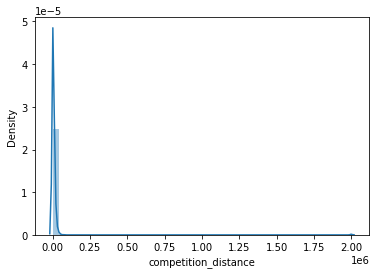

In [ ]:
sns.distplot(df1['competition_distance'])

#### 1.7.2 Categorical Attributes - Descriptive Statistical 

In [ ]:
#visualizar quantas variaçoes de cada elemento categorico existem
cat_attributes.apply(lambda x: x.unique().shape[0])

date              942
state_holiday       4
store_type          4
assortment          3
promo_interval      4
month_map          12
dtype: int64

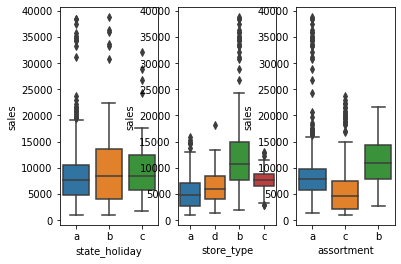

In [ ]:
# Aplicando um bloxplot pra entender a concentração dos dados de cada variavel
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# state holiday
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

# store type
plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

# assortment
plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

## 2.0 Feature Engineering


In [ ]:
df2 = df1.copy()

### 2.1 Mapa mental de Hipoteses

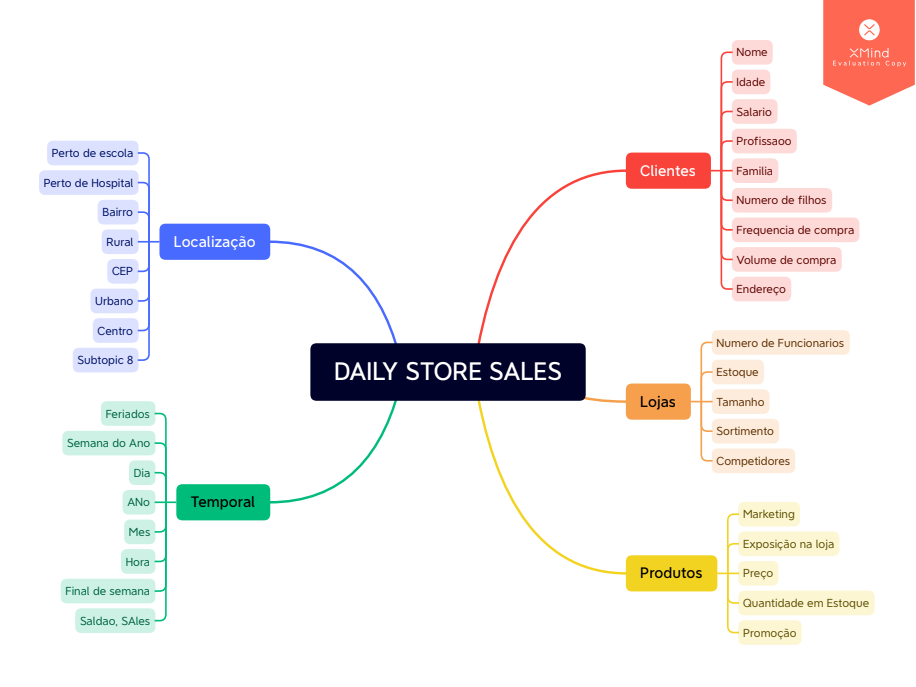

In [ ]:
Image('/content/drive/MyDrive/Colab Notebooks/Data Science Em Produção/Projeto Rossman Store/img/Mapa Mental de Hipoteses - Rossman Store.png')

### 2.2 Criação de Hipoteses

#### 2.2.1 Hipoteses da Loja

1. Lojas com maior quadro de funcionarios vendes mais  
2. Lojas com maior estoque vendem mais
3. Lojas com maior porte deveriam vender mais
4. Lojas com menor porte deveriam vender menos
5. Lojas com Maior Sortimento deverias vender mais

#### 2.2.2 Hipoteses do Produto

1. Lojas que investes em marketing deveriam vender mais
2. Lojas que investes expoe mais produtos nas vitrines deveriam vender mais
3. Lojas que tem menores preços deveriam vender mais
4. Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais

#### 2.2.3 Hipoteses do Tempo

1. Lojas que tem mais feriados deveriam vender menos
2. Lojas que abrem nos primeiro 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais
4. Lojas Deveriam vender mais no segundo semestre do ano

### 2.3 Lista de Hipoteses

1. Lojas com Maior Sortimento deverias vender mais
2. Lojas com competidores mais proximos deveriam vender menos
3. Lojas com competidores à mais tempo deveriam vender mais


1. Lojas com promoções ativas a mais tempo deveriam vender mais
2. Lojas com mais dias de promoção deveriam vender mais
3. Lojas com mais promoçoes consecutivas deveram vender mais.

1. Lojas Abertas durante o feriado de natal deveriam vender mais
1. Lojas deveriam vender mais ao longo do anos
4. Lojas Deveriam vender mais no segundo semestre do ano
1. Lojas deveriam vender mais depois do 10 dia util do mes
1. Lojas deveriam vender menos aos finais de semana
1. Lojas que tem mais feriados deveriam vender menos
1. lojas deveriam vender menos durante os feriados escolares
2. Lojas que abrem nos primeiro 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais.


### 2.4 Derivar Features (Feature Engineering)

In [ ]:
# Variaveis a Derivar:

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# day
df2['day'] = df2['date'].dt.day


# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition sice
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1) #quando o tiver mais de uma colunas envolvida, o Axis precisa ser igual a 1, pra passar por todas as colunas
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7 ).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == "a" else 'extra' if x == "b" else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [ ]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

## 3.0 Filtragem de Variaveis

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,week_of_year,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtragem das linhas

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] 

### 3.2 Seleção das Colunas

In [ ]:
cols_drop = ['customers', 'open', 'month_map', 'promo_interval']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Analise Exploratoria dos Dados (EDA)

In [ ]:
df4 = df3.copy()

## 4.1 Analise Univaridada


### 4.1.1 Response Variable

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


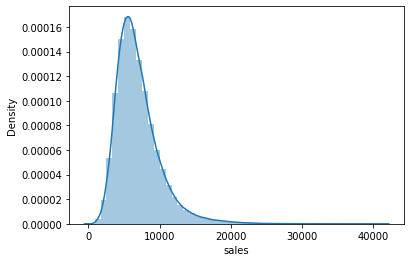

In [ ]:
sns.distplot(df4['sales'])

# Analise do Grafico Resultante:
## Tem formato de sino
## Tem [Curtose]
## Tem [Skew] pra esquerda, Logo é positiva
## Pode Nao estar centrada, mas é um problema problemas
## Está bem proxima à [Normal], mas nao é [Normal]

### 4.1.2 Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34bfb11070>,
      dtype=object)

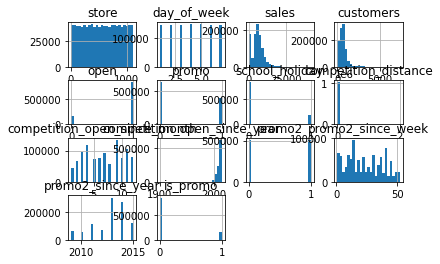

In [ ]:
num_attributes.hist( bins=25)


# Analise dos graficos das variaveis
# o promo2_since_week te fica bem maior depois prox as semenas 0, 10, 20, 30 e 40
# o competition distance fica muito maior perto do do zero, o que quer dizer que temos muitas lojas com competidores perto
# o comptetitin open since month dica maior nos meses 4 e 9 e o primeiro quarter é totalmente crescente, enquanto o segundo é crescente ate o ultimo mes do quarter, ja o 3 quarter tem seu pico no primeiro mes
# a lista is_promo fica maior no 0, por que a maioria das lojas nao fez a venda em promoçao
# no atributo open loja tem mais dias abertos que fechados
# no grafico de promo, o numero de lojas com promo é quase metade das que nao tem promo
# 

### 4.1.3 Categorical Variable

In [ ]:
cat_attributes.head()

,date,state_holiday,store_type,assortment,promo_interval,month_map
0,2015-07-31,0,c,a,0,Jul
1,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,2015-07-31,0,c,c,0,Jul
4,2015-07-31,0,a,a,0,Jul


In [ ]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


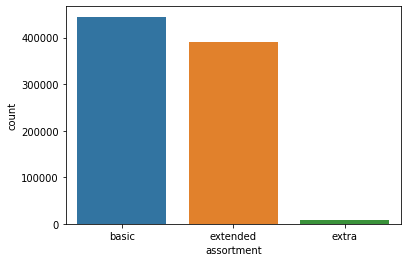

In [ ]:
sns.countplot(df4['assortment'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-36-92a3b0a4a640>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3 ,2, 2)
<ipython-input-36-92a3b0a4a640>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the futu

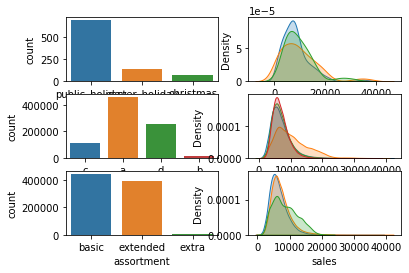

In [ ]:
# 'state_holiday'

# criar um grid com subplot pra mostar os dois graficos sobrepostos
# configurando a matriz com 1 linhas, duas colunas e plotando na primeira posição o primeiro grafico
plt.subplot(3 ,2, 1)

## aplicar um count para entender de volume de cada variavel 
a = df4[df4['state_holiday'] != 'regular_day'] # filtrando a variavel state+holiday por que ela se destaca mito em relação as outas, isso atrapalha a comparação das demais
sns.countplot(a['state_holiday']) # aplicando um countplot pra mostrar um grafico da contagem de elementos
# aplos essa analise, vemos que os feirados vem em ordem decrescente como: Feriados publicos, feriados estaduais e natal


# aqui plotar o segundo grafico na segunda posição
plt.subplot(3 ,2, 2)
# usando o kdeplot pra filtrar o numero de vendas dos #feriados publicos, estaduais e natal respectivamente
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
plt.subplot(3 ,2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
plt.subplot(3 ,2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)



# 'store_type'
# vamos aplicar a mesma logica descrita na variavel state_holiday, contar quanto de cada um tem e mostrar a relaçao com vendas de cada 1
plt.subplot(3 ,2, 3)
sns.countplot(df4['store_type']) # aplicando um countplot pra mostrar um grafico da contagem de elementos


# aqui plotar o segundo grafico na segunda posição
plt.subplot(3 ,2, 4)
# usando o kdeplot pra filtrar o numero de vendas dos tipos de loja: publicos, estaduais e natal respectivamente
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
plt.subplot(3 ,2, 4)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
plt.subplot(3 ,2, 4)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
plt.subplot(3 ,2, 4)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)


# 'assortment'
# vamos aplicar a mesma logica descrita na variavel state_holiday, contar quanto de cada um tem e mostrar a relaçao com vendas de cada 1
plt.subplot(3 ,2, 5)
#a = df4[df4['store_type'] != 'regular_day'] # filtrando a variavel state+holiday por que ela se destaca mito em relação as outas, isso atrapalha a comparação das demais
sns.countplot(df4['assortment']) # aplicando um countplot pra mostrar um grafico da contagem de elementos


# aqui plotar o segundo grafico na segunda posição
plt.subplot(3 ,2, 6)
# usando o kdeplot pra filtrar o numero de vendas dos tipos de loja: publicos, estaduais e natal respectivamente
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
plt.subplot(3 ,2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
plt.subplot(3 ,2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


## 4.2 Analise Bivariada

####H1. Lojas com Maior Sortimento deverias vender mais

RESULTADO: **Falso** 

- Lojas com Sortimento maior, <u>vendem menos 


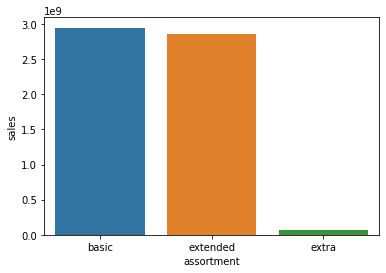

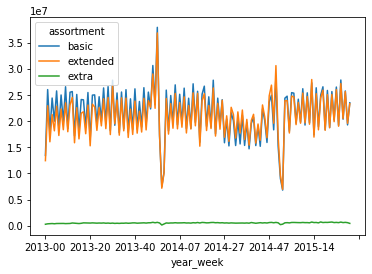

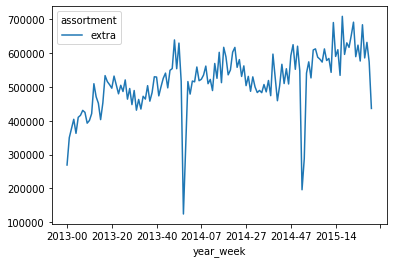

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Resultados:
## os assortments basic e extended tem praticamente o mesmo volume de vendas
## o assortment extra na verdade tem menos vendas do que os outras duas categorias

# nova hipotese: vamos analisar se a baixa venda do assortment seja na verdade uma variação pelo tempo
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

# RESULTADO DA HIPOTESE: Lojas com Sortimento maior, vendem menos (DESVALIDADO)

####H2. Lojas com competidores mais proximos deveriam vender menos
RESULTADO: **Falso**

- Lojas com competidores mais proximos <u>vendem MUITO mais

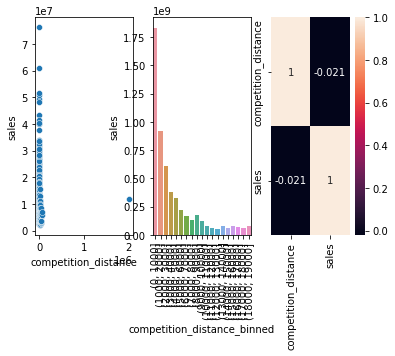

In [ ]:
# df auxiliar onde vamos agrupar as vendas pela distancia do competidor de cada loja
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Grafico de pontos: pra ter uma visao melhor dos dados muitos granulares
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)


# Grafico de Barras para entender a distribuição das vendas em grupos de distancias
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000)) # criando grupos de arrays que vao de 0 ate 20000 e agrupa os elementos de 1000 em 1000
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation = 90)

# Calcular a força da correlação:
plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);



# Resultado da analise:
## lojas com competidores proximos vendem, em disparado, mais que lojas sem competidores muito proximo
## isso gera uma insigth contra intuitivo onde achavamos que vendiamos mais quando nao tinha concorrente proximo
## Talvez por que o comercio local sendo forte, estimula a compra, quando uma pessoa compra, independente de onda, outra tambem vao querer comprar
### isso explicar por que sempre temos farmacias perto uma das outras, tambem se aplicar pra supermercados e fastfood


#### H3. Lojas com competidores à mais tempo deveriam vender mais
 RESULTADO: **Falso**

- Lojas com competidores recem abertos <u>vendem muito mais</u> que lojas com competidores a mais tempo


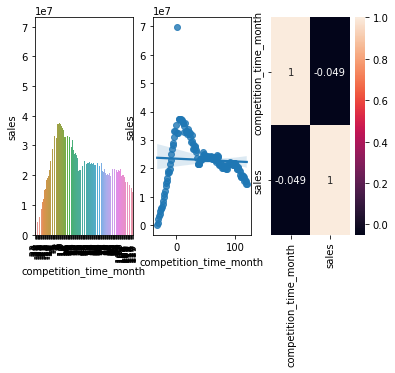

In [ ]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation =90);

# aplicar uma segunda visualização pra reafirmar o desvio
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

#medir a força da correlação
plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);
# RESULTADO DA HIPOTESE: DESVALIDADO
## Lojas com competidores recem abertos vendem muito mais que lojas com competidores a mais tempo


####H4. Lojas com Promoções ativas por mais tempo deveriam vender mais
Resultado: **Falso**
- Lojas com promoção extendida por muito tempo <u>vendem menos

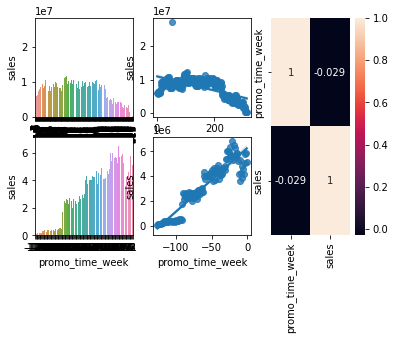

In [ ]:

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promoção extendida
sns.barplot(x ='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x ='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promoção Regular
sns.barplot(x ='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[1, 1])
sns.regplot(x ='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Usamos o regplot pra tentar confirmar se a tendencia da promoção era crescente de fato 

### ANALISE DO RESUTALDO
# Lojas que tem promoção extendida, ao passar do tempo tem um decaimento nas vendas
## isso pode significar que as depois de uma tempo o efeito "promoção" perder a eficacia

# por outro lado, durante a promoção regular, as lojas vao tendo um aumento nas vendas ate chegar em um pico
## isso deve ser resultado de um conjunto de fatores, atrelados ao marketing e ao evento 


####<s>H5. Lojas com mais dias de promoção deveriam vender mais</s>


In [ ]:
# vamos analisar essa hipotese na segunda variavel do Crispy, porque ainda seria necessario criar outras coluna pra analisar isso


####H6. Lojas com Mais promoções consecutivas deveriam vender mais
Resultado: **Falso**
- As lojas com Mais promoções consecutivas <u>vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# aqui temos que as lojas que se sairam melhor foram que as entrarem apenas na promo regula
# em compensação as que entraram qpenas na promo2 foram as que menos venderam

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


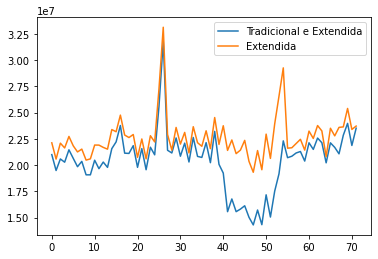

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax );

ax.legend(labels=['Tradicional e Extendida', 'Extendida']);


# Resultado da validação: Desvalidado
## Lojas com mais promoçõe consecutivas nao vendem mais, o volume é similar na maior parte do tempo, e ate menor em um intervalo especifico

####H7. Lojas Abertas durante o feriado de natal deveriam vender mais
RESULTADO: **Falso**
- os feriados publicos tem muitos mais vendas que o natal


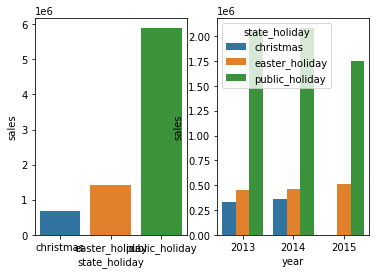

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1);
# essa seção ja desvalida a hipotese, os feriados publicos tem muitos mais vendas que o natal


plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2);
# mesmo com o passar dos anos, as lojas vendem bem mais nos feriados publicos

####H8. Lojas deveriam vender mais ao longo do anos
Validação: **Falsa**
- as lojas estao vendendo <u>menos com o passar dos anos

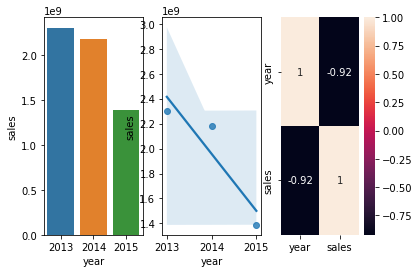

In [ ]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

# analisar a tendencia
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1); # tendencia decrescente

# Calcular a força da correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True); # correlação muito forte de decrescimento, decorrente do ano ainda nao ter terminado 

####H9. Lojas Deveriam vender mais no segundo semestre do ano
Validação: *Falsa*
- as lojas estao <u>vendendo menos</u> no segundo semestre do ano

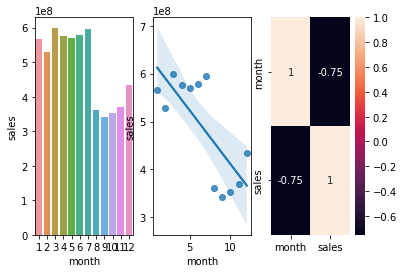

In [ ]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

# analisar a tendencia
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1); # tendencia decrescente, vendem menos durante primeiro semestre

# Calcular a força da correlação
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True); # correlação muito forte de decrescimento, decorrente do ano ainda nao ter terminado 

####H10. Lojas deveriam vender mais depois do 10 dia util do mes
Validação: **Verdadeira**
- as lojas estao <u>vendem mais</u> depois do dia 10

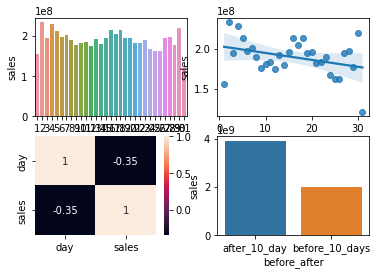

In [ ]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

# analisar a tendencia
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1); 
# Calcular a força da correlação
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True); # correlação media

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: "before_10_days" if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)

####H11. Lojas deveriam vender menos aos finais de semana
Validação: **Verdadeira**
- as lojas estao <u>vendendo menos</u> durane o fim de semana

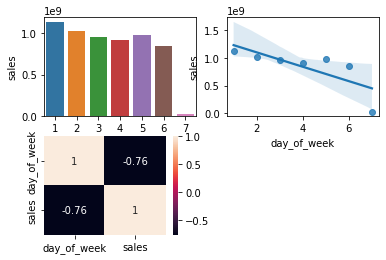

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

# analisar a tendencia
plt.subplot(2,2,2)
sns.regplot(x='day_of_week', y='sales', data=aux1); 
# Calcular a força da correlação
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

####H12. Lojas deveriam vender menos durante feriados escolares
Resultado: **Verdadeiro**
- Lojas <u>vendem menos</u> durante os feriados, com a *resalva de julho e agosto*, onde a logica inverte

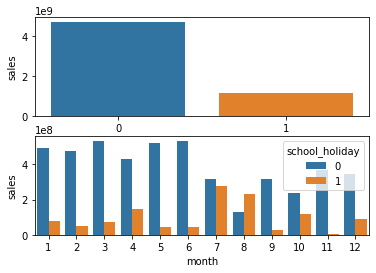

In [ ]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);
# as vendas durante o feriado escolar sao bem menores


aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);
# durante o periodo de ferias de julho, as vendas se equipara, como os alunos estao de ferias, os feiados nao se aplicam




### Resumo das Hipoteses

In [ ]:
tab = [['Hipotese','Conclusão','Relevancia'],
       ['h1','falso','baixa',],
       ['h2','falso','media',],
       ['h3','falso','media',],
       ['h4','falso','baixa',],
       ['h5','-','-',],
       ['h6','falso','baixa',],
       ['h7','falso','media',],
       ['h8','falso','alta',],
       ['h9','falso','alta',],
       ['h10','verdadeiro','alta',],
       ['h11','verdadeiro','alta',],
       ['h12','verdadeiro','baixa',],
       ]

print(tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevancia
----------  -----------  ------------
h1          falso        baixa
h2          falso        media
h3          falso        media
h4          falso        baixa
h5          -            -
h6          falso        baixa
h7          falso        media
h8          falso        alta
h9          falso        alta
h10         verdadeiro   alta
h11         verdadeiro   alta
h12         verdadeiro   baixa


## 4.3 Analise Multivariada

#### 4.3.1. Numerical Attributes

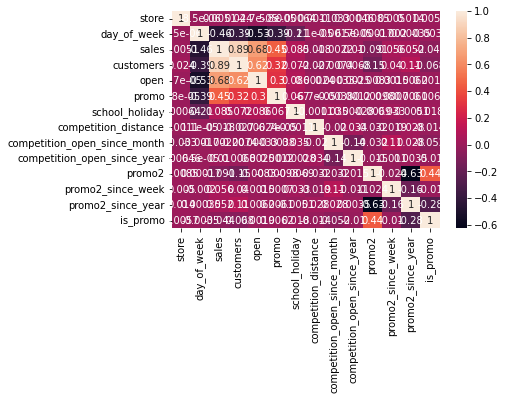

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

#### 4.3.2. Categorical Attributes

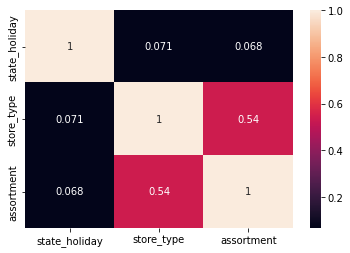

In [ ]:
# seleção das variavies categoricas
a = df4.select_dtypes(include='object')

# Aplicação do Cramer_V 
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9= cramer_v( a['assortment'], a['assortment'] )

# DataSet Final
d = pd.DataFrame({"state_holiday": [a1, a2, a3],
                  "store_type": [a4, a5, a6],
                  "assortment": [a7, a8, a9] })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 Preparação dos dados

In [ ]:
df5 = df4.copy()

## 5.1. Normalização

In [ ]:
## Como nenhuma tabela numerica tem Normal, optei por nao fazer a normalização e pular para o Rescaling

## 5.2. Rescaling

In [ ]:
#Seleção das Variaveis numericas
a = df5.select_dtypes(include=['int64', 'float64'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


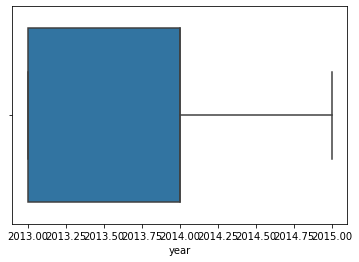

In [ ]:
sns.boxplot( df5['year'] );

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# Competition_distance
df5['competition_distance']  = rs.fit_transform(df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month']  = rs.fit_transform(df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week']  = mms.fit_transform(df5[['promo_time_week']].values )

# year
df5['year']  = mms.fit_transform(df5[['year']].values )

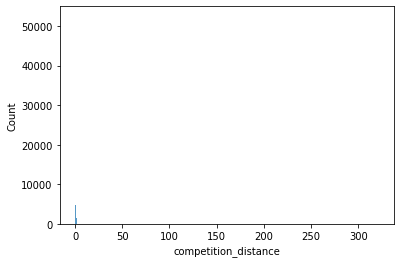

In [ ]:
sns.histplot(df5['competition_distance']);

## 5.3. Transformation

### 5.3.1 Encoding


In [ ]:
# State Holiday: Variavel de Estado
# One Hot Encode
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# Store_type: Variavel de sem ordem especifica 
# Label Encode
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Assortiment:Variaveis com uma ordem de grandeza especifica
# Ordinal Encoder
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation


In [ ]:
df5['sales'] = np.log1p( df5['sales'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


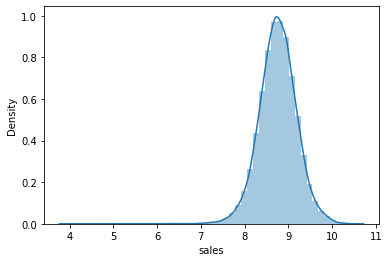

In [ ]:
sns.distplot(df5['sales'])

### 5.3.3 Natural Transformation

In [ ]:
# Variaveis Numericas ciclicas

# mont1
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

In [ ]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Feature Selection

In [ ]:
df6 = df5.copy()


In [ ]:
# exportando DF para tratamento em ambiente local
# vamou utilizar o boruta em ambiente separado para nao sobrecarregar a RAM do Colab

# df6.to_csv('df6.csv')
# files.download('df6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6.1 Split dataframe into training and test dataset

In [6]:
# Apos abrir um ambientre exclusivo para rodar o boruta, importamos devolta os dados
# df6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science Em Produção/Projeto Rossman Store/Data/df6.csv')

In [ ]:
# removendo variaveis que ja foram preparadas
cols_drop = ['week_of_year', 'day', 'year_week', 'month', 'day_of_week', 'promo_since', 'competition_since']
df6 = df6.drop(cols_drop, axis = 1)

In [ ]:
# Extraindo data 6 meses antes da ultima vendas para usar no teste
# Só precisa ser feito uma vez
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)
#incio: 2013-01-02 
#final: 2015-07-31

In [11]:
# Training DataSet
x_train = df6[ df6['date'] < '2015-06-09']
y_train = x_train['sales']

# Test DataSet
x_test = df6[ df6['date'] >= '2015-06-09']
y_test = x_test['sales']

print(f"Training Min Date: {x_train['date'].min()}") 
print(f"Training Max Date: {x_train['date'].max()}") 

print(f"\nTest Min Date: {x_test['date'].min()}") 
print(f"Test Max Date: {x_test['date'].max()}") 

Training Min Date: 2013-01-01
Training Max Date: 2015-06-08

Test Min Date: 2015-06-09
Test Max Date: 2015-07-31


## 6.2 Boruta as Freature Selector 

In [12]:
# training and test dataset for Boruta
x_train_n = x_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RadomForestRegressor
rf = RandomForestRegressor(n_jobs=-1,)

# define boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


In [15]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected_boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.2 Manual Freature Selector 

In [22]:
# vamos salvar o resultado do boruta em uma lista para nao precisar rodar sempre que iniciar o notebook
#colunas selecionadas pelo boruta
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# columns to add
feet_to_add = ['date', 'sales']

# final features
cols_selected_boruta.extend(feet_to_add)

# Colunas rejeitadas pelo boruta 
cols_not_selected_boruta = [
 'is_promo',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year']